In [1]:
import sys

if not 'pandas' in sys.modules:
    !pip install -U 'pandas'==1.5.3
if not 'numpy' in sys.modules:
    !pip install -U 'numpy'==1.24.4
if not 'os' in sys.modules:
    !pip install -U 'os'       
if not 'glob' in sys.modules:
    !pip install -U 'glob'       
if not 'matplotlib' in sys.modules:
    !pip install -U 'matplotlib'      
if not 'seaborn' in sys.modules:
    !pip install -U 'seaborn'          
if not 're' in sys.modules:
    !pip install -U 're'   
if not 'scipy' in sys.modules:
    !pip install -U 'scipy'
if not 'scikit-learn' in sys.modules:
    !pip install -U 'scikit-learn'
if not 'haversine' in sys.modules:
    !pip install -U 'haversine'   
if not 'pyarrow' in sys.modules:
    !pip install -U 'pyarrow' 
if not 'folium' in sys.modules:
    !pip install -U 'folium' 
if not 'webbrowser' in sys.modules:
    !pip install -U 'webbrowser' 
if not 'geopandas' in sys.modules:
    !pip install -U 'geopandas' 

ERROR: Could not find a version that satisfies the requirement webbrowser (from versions: none)
ERROR: No matching distribution found for webbrowser


In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
from haversine import haversine, Unit
from os.path import join
from pathlib import Path
import folium
import webbrowser as web
import geopandas as gpd
from folium import plugins
from sklearn.preprocessing import MinMaxScaler

<h3>Global parameters</h3>
<ul>
    <li>Day [day]</li>
    <li>Time Window [tw]</li>
    <li>Connection duration [cd]</li>
    <li>Walking speed [ws]</li>
</ul>

In [2]:
day = 11
tw = 5
cd = [30, 1200]
ws = 1

<h3>Load tracking events and bus stop data</h3>
<p>Each event is a log that marks the passage of a bus through a bus stop. Firstly, everything is loaded, and second it is filtered from 6:00 to 19:59.</p>

In [3]:
def extract_terminal_name(x):
    if isinstance(x, str):
        pattern = r'Terminal (Capão da Imbuia|Pinheirinho|Portão|Bairro Alto|Barreirinha|Boa Vista|Boqueirão|Cabral|Cachoeira|Caiuá|Campina do Siqueira|Campo Comprido|Capão Raso|Carmo|Centenário|CIC|Fazendinha|Hauer|Maracanã|Oficinas|Pinhais|Santa Cândida|Santa Felicidade|Sítio Cercado|Tatuquara)'

        match = re.search(pattern, x)
        if match:
            return match.group()
    return x

# ----------------------------------------------------------
# Tracking events
# ----------------------------------------------------------
vw_event = pd.read_parquet("vw_event.parquet")
vw_event['hour'] = vw_event["event_timestamp"].dt.hour
vw_event['base_date'] = pd.to_datetime(vw_event["base_date"])
vw_event.query("6 <= hour <= 19", inplace = True)

# ----------------------------------------------------------
# Bus stops + normalization of names
# ----------------------------------------------------------
dim_bus_stop = pd.read_parquet("dim_bus_stop.parquet").query("type_norm not in (['Others','Dawn bus','Tourism line'])").drop(columns=['last_update'])
dim_bus_stop['name_normalized'] = np.where((dim_bus_stop.type_norm == 'Bus terminal'), dim_bus_stop.name, '')
dim_bus_stop['name_normalized'] = dim_bus_stop['name_normalized'].apply(extract_terminal_name)
dim_bus_stop['type_norm'] = np.where((dim_bus_stop.type_norm == 'Bus terminal'), 'Tube station', dim_bus_stop.type_norm)
terminais_dummy_ids = dim_bus_stop.query("~name_normalized.isna() and name_normalized != ''").groupby(['name_normalized']).agg(dummy_legacy_id = ('legacy_id', 'sum')).reset_index()
dim_bus_stop = dim_bus_stop.merge(terminais_dummy_ids, on=['name_normalized'], how='left')
dim_bus_stop['dummy_legacy_id'] = np.where( (dim_bus_stop.name_normalized == '') , dim_bus_stop.legacy_id, dim_bus_stop.dummy_legacy_id)
dim_bus_stop['dummy_legacy_id'] = dim_bus_stop.dummy_legacy_id.astype(int)

# ----------------------------------------------------------
# Consolidation of events + normalized points
# ----------------------------------------------------------
bs = dim_bus_stop.copy()
bs['name_normalized'] = np.where((bs.name_normalized == ''), bs.name, bs.name_normalized)
bs = bs.filter(['dummy_legacy_id', 'name_normalized', 'type_norm', 'latitude', 'longitude']).groupby(by = ['dummy_legacy_id', 'name_normalized', 'type_norm']).agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index()
b = pd.merge(vw_event.filter(['line_code', 'itinerary_id', 'vehicle', 'legacy_id', 'seq', 'event_timestamp', 'base_date', 'month', 'day', 'weekday', 'hour']), dim_bus_stop.filter(['legacy_id', 'dummy_legacy_id']), left_on = 'legacy_id', right_on = 'legacy_id', how = 'left').drop(columns = ['legacy_id'])
events = pd.merge(b, bs)
events.dummy_legacy_id = events.dummy_legacy_id.astype('int')
events['year'] = events['event_timestamp'].dt.year
events['month'] = events['event_timestamp'].dt.month
events['day'] = events['event_timestamp'].dt.day
events['weekday'] = events['event_timestamp'].dt.weekday
events['hour'] = events['event_timestamp'].dt.hour
conditions = [
    ((events.hour >= 6) & ((events.hour <= 8))),
    ((events.hour >= 11) & ((events.hour <= 13))),
    ((events.hour >= 17) & ((events.hour <= 19)))
]
period_choices = ['Morning', 'Midday', 'Evening']
events['period'] = np.select(conditions, period_choices, default = 'N/A')
events.query(f'day == {day}', inplace = True)

<h3>Compute bus service</h3>
<p>The bus service is evaluated in a time window of <b>tw</b> minutes, representing an expected waiting time for most users. The number of buses of a line code that pass a stop is counted considering a time windows of <b>tw</b> minutes. This way, buses within a time window of <b>tw</b> minutes are counted. For each combination of bus stop and line code, a time series represents the number of buses observed in a <b>tw</b>-minute time interval during the day.</p>

In [4]:
events['time_window'] = (60 * events["event_timestamp"].dt.hour + events["event_timestamp"].dt.minute).floordiv(tw)
df_bus_availability = events.groupby(['dummy_legacy_id','line_code','year','month','day','weekday','hour','time_window']).size().reset_index(name = 'bus_count')
dim_bus_stop = events.filter(['dummy_legacy_id','line_code']).drop_duplicates()
dim_time = events.filter(['year','month','day','weekday','hour','time_window']).drop_duplicates()
df_bus_availability = pd.merge(pd.merge(dim_bus_stop, dim_time, how = 'cross'), df_bus_availability, how = 'left').fillna(0)
df_bus_availability = pd.merge(df_bus_availability, bs, on = "dummy_legacy_id")
period_choices = ['Morning', 'Midday', 'Evening']
conditions = [
    ((df_bus_availability.hour >= 6) & ((df_bus_availability.hour <= 8))),
    ((df_bus_availability.hour >= 11) & ((df_bus_availability.hour <= 13))),
    ((df_bus_availability.hour >= 17) & ((df_bus_availability.hour <= 19)))
]
df_bus_availability['period'] = np.select(conditions, period_choices, default = 'N/A')

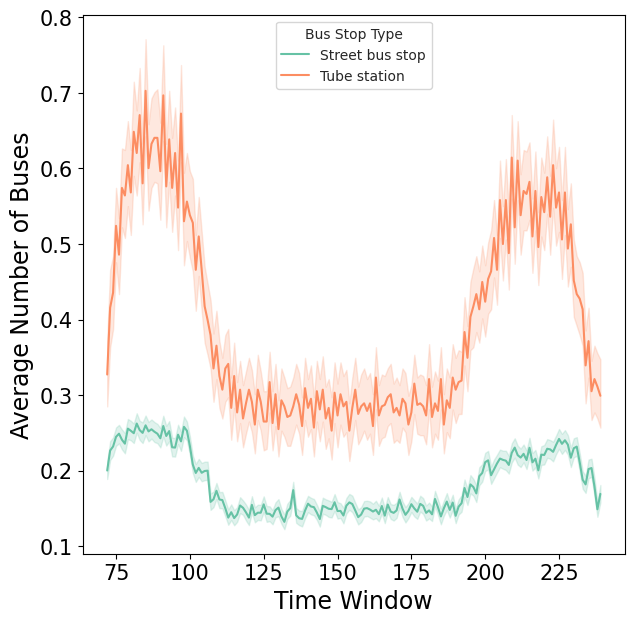

In [5]:
fig, axes = plt.subplots(figsize = (7, 7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(x = df_bus_availability.time_window, y = df_bus_availability.bus_count, estimator = 'mean', errorbar = ('ci', 95), hue = df_bus_availability.type_norm, legend = True, palette = sns.color_palette("Set2", 2))
g.tick_params(labelsize = 15)
g.set_ylabel("Average Number of Buses", fontsize = 17)
g.set_xlabel("Time Window", fontsize = 17)
plt.legend(title = 'Bus Stop Type', loc = 'upper center');

<h3>Positive edges loading</h3>
<p>Firstly, everything is loaded, and second it is tagged by period:</p>
<ul>
    <li>Morning: 6:00 to 8:59 am</li>
    <li>Midday: 11:00 to 13:59</li>
    <li>Evening: 17:00 to 19:59</li>

In [6]:
parquet_files = glob.glob("connections_20min/*.parquet")
positive_edges = [pd.read_parquet(f) for f in parquet_files]
positive_edges = pd.concat(positive_edges, ignore_index = True)
positive_edges['event_timestamp_u'] =  pd.to_datetime(positive_edges["event_timestamp_u"])
positive_edges['event_timestamp_v'] =  pd.to_datetime(positive_edges["event_timestamp_v"])
positive_edges = positive_edges.groupby(by = ['dummy_legacy_id_u', 'dummy_legacy_id_v', 'line_code_u', 'line_code_v', 'vehicle_u', 'vehicle_v', 'event_timestamp_u']).event_timestamp_v.max().reset_index()
positive_edges['year'] = positive_edges['event_timestamp_u'].dt.year
positive_edges['month'] = positive_edges['event_timestamp_u'].dt.month
positive_edges['day'] = positive_edges['event_timestamp_u'].dt.day
positive_edges['weekday'] = positive_edges['event_timestamp_u'].dt.weekday
positive_edges['hour'] = positive_edges['event_timestamp_u'].dt.hour
positive_edges['base_date'] = pd.to_datetime(dict(year=positive_edges.year, month=positive_edges.month, day=positive_edges.day))
positive_edges['duration'] = (positive_edges.event_timestamp_v - positive_edges.event_timestamp_u).astype('timedelta64[s]')
positive_edges.drop_duplicates(inplace = True)

conditions = [
    ((positive_edges.event_timestamp_v.dt.hour >= 6) & ((positive_edges.event_timestamp_v.dt.hour <= 8))),
    ((positive_edges.event_timestamp_v.dt.hour >= 11) & ((positive_edges.event_timestamp_v.dt.hour <= 13))),
    ((positive_edges.event_timestamp_v.dt.hour >= 17) & ((positive_edges.event_timestamp_v.dt.hour <= 19)))
]

period_choices = ['Morning', 'Midday', 'Evening']
positive_edges['period'] = np.select(conditions, period_choices, default = 'N/A')
positive_edges.query(f'day == {day}', inplace = True)

positive_edges['time_window'] = (60 * positive_edges["event_timestamp_v"].dt.hour + positive_edges["event_timestamp_v"].dt.minute).floordiv(tw)
positive_edges['group_id'] = positive_edges.groupby(by = ['dummy_legacy_id_u', 'dummy_legacy_id_v', 'line_code_u', 'line_code_v']).ngroup()

<h3>Filter positive edges by feasible walking time</h3>

In [7]:
def dist(connection):
    u = list(bs.query(f"dummy_legacy_id == {connection['dummy_legacy_id_u']}")[['latitude', 'longitude']].itertuples(index=False, name=None))[0]
    v = list(bs.query(f"dummy_legacy_id == {connection['dummy_legacy_id_v']}")[['latitude', 'longitude']].itertuples(index=False, name=None))[0]
    dist = haversine(u, v, unit = Unit.METERS)
    return dist

distance = positive_edges[['dummy_legacy_id_u', 'dummy_legacy_id_v']].drop_duplicates()
distance['walking_distance'] = distance.apply(lambda row: dist(row), axis = 1);
positive_edges = pd.merge(positive_edges, distance)
positive_edges['walking_time'] = positive_edges.walking_distance / ws
positive_edges.query('walking_time < duration', inplace = True)

<h3>Crossing positive edges and bus availability</h3>

In [8]:
pe = positive_edges.query(f"duration >= {cd[0]} and duration <= {cd[1]}").copy()
pe = pe.groupby(['dummy_legacy_id_u', 'dummy_legacy_id_v', 'line_code_u', 'line_code_v', 'group_id']).size().reset_index(name='conn_count')
ba = df_bus_availability.copy()
ba = ba.groupby(['dummy_legacy_id', 'line_code']).bus_count.sum().reset_index()
df_analise_edges = pd.merge(pe, ba, left_on = ['dummy_legacy_id_u', 'line_code_u'], right_on = ['dummy_legacy_id', 'line_code'], how = 'inner')
df_analise_edges = pd.merge(df_analise_edges, ba, left_on = ['dummy_legacy_id_v', 'line_code_v'], right_on = ['dummy_legacy_id', 'line_code'], how = 'inner')
df_analise_edges.rename(columns = {'bus_count_x': 'bus_count_u', 'bus_count_y': 'bus_count_v'}, inplace = True)
df_analise_edges.drop(columns = ['dummy_legacy_id_x', 'dummy_legacy_id_y', 'line_code_x', 'line_code_y'], axis = 1, inplace = True)
df_analise_edges['min_bus_count'] = df_analise_edges.filter(['bus_count_u', 'bus_count_v']).min(axis = 1)

In [9]:
# Normalizando a coluna 'freq' pela coluna 'stop_count'
df_analise_edges['conn_count_normalized'] = df_analise_edges['conn_count'] / df_analise_edges['min_bus_count']

# Aplicando Min-Max Scaling para garantir que os valores estejam entre 0 e 1
scaler = MinMaxScaler()
df_analise_edges['conn_count_normalized'] = scaler.fit_transform(df_analise_edges[['conn_count_normalized']])

# Visualizar as primeiras linhas do DataFrame para conferir a normalização
df_analise_edges.head()

,dummy_legacy_id_u,dummy_legacy_id_v,line_code_u,line_code_v,group_id,conn_count,bus_count_u,bus_count_v,min_bus_count,conn_count_normalized
0,101004,101005,876,207,0,41,34.0,53.0,34.0,0.180477
1,101005,101005,260,207,64,18,12.0,53.0,12.0,0.226006
2,101121,101005,901,207,225,64,59.0,53.0,53.0,0.180735
3,101131,101005,160,207,350,20,21.0,53.0,21.0,0.141235
4,101131,101005,164,207,352,24,22.0,53.0,22.0,0.162679


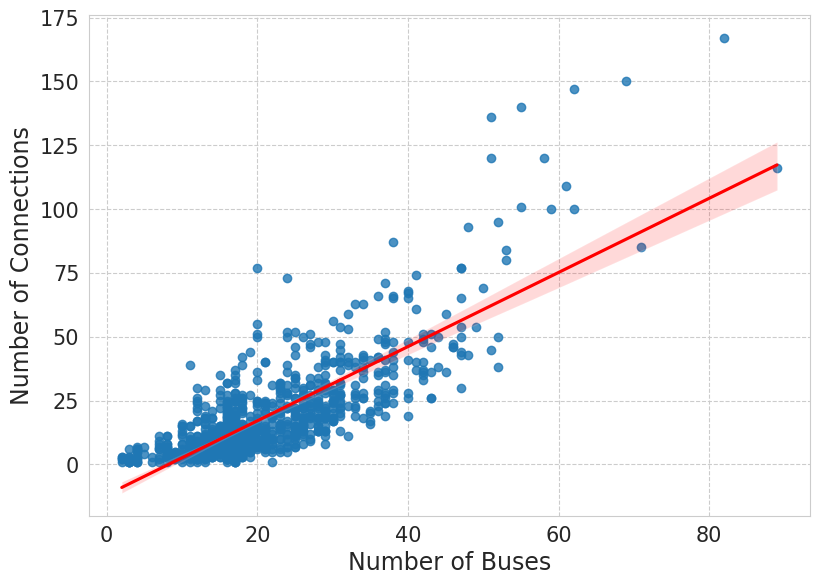

In [10]:
x = df_analise_edges.sample(n = 1000)
fig, axes = plt.subplots(figsize = (9.3, 6.5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.regplot(x = x.min_bus_count, y = x.conn_count, ci = 95, ax = axes, line_kws = {'color': 'red'})
g.tick_params(labelsize = 15)
g.set_xlabel("Number of Buses", fontsize = 17)
g.set_ylabel("Number of Connections", fontsize = 17);

In [11]:
scipy.stats.pearsonr(x = x.min_bus_count, y = x.conn_count)

PearsonRResult(statistic=0.8014028701127761, pvalue=5.451283745375945e-225)

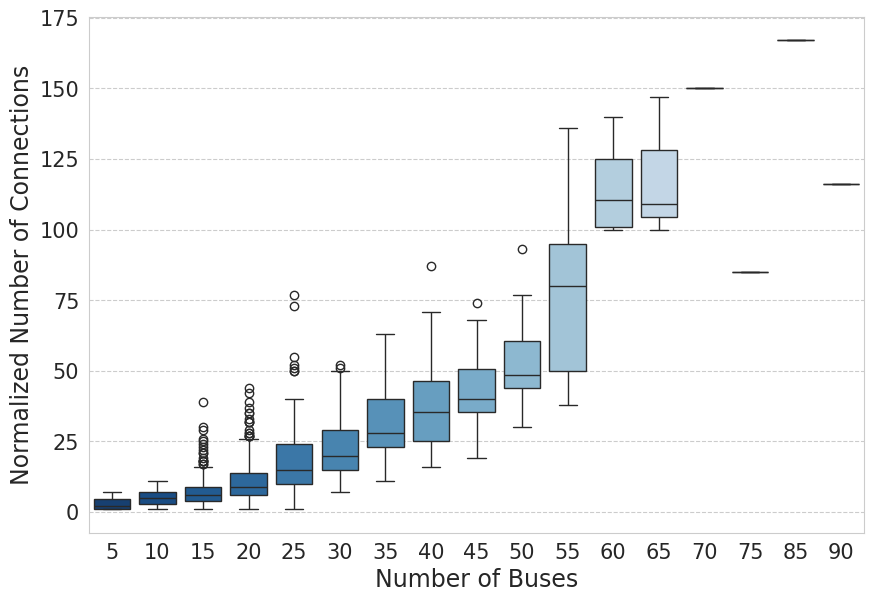

In [12]:
fig, axes = plt.subplots(figsize = (10, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
x['min_bus_count_group'] = 5 * (1 + x.min_bus_count / 5).astype('int32')
g = sns.boxplot(x = x.min_bus_count_group, y = x.conn_count, linewidth = 1.0, palette = sns.color_palette("Blues_r", len(x.min_bus_count_group.unique())), hue = x.min_bus_count_group, notch = False, showfliers = True, ax = axes, legend = False)
g.tick_params(labelsize = 15)
g.set_xlabel("Number of Buses", fontsize = 17)
g.set_ylabel("Normalized Number of Connections", fontsize = 17);

<h3>Compute Cluster Metrics</h3>

In [96]:
bus_stop_clustered = pd.read_parquet('bus_stop_clustered.parquet')
df_cluster = pd.merge(df_analise_edges, bus_stop_clustered[['legacy_id', 'cluster']], left_on = 'dummy_legacy_id_u', right_on = 'legacy_id', how = 'inner')
agg_cluster = df_cluster.groupby('cluster').agg(
    transfer_count = ('group_id', 'nunique'), 
    conn_count = ('conn_count', 'sum'),
    conn_count_normalized = ('conn_count_normalized', 'mean'),
    bus_stop_count = ('dummy_legacy_id_u', lambda x: len(set(x.unique()) | set(df_cluster[df_cluster['cluster'] == x.name]['dummy_legacy_id_v'].unique()))),
    bus_line_count = ('line_code_u', lambda x: len(set(x.unique()) | set(df_cluster[df_cluster['cluster'] == x.name]['line_code_v'].unique())))
).reset_index()

<h4>Cluster Density</h4>
Cluster density represents the total number of connections within a specific cluster.

In [97]:
mean, std, q1, median, q3 = agg_cluster.conn_count.mean(), agg_cluster.conn_count.std(), agg_cluster.conn_count.quantile(0.25), agg_cluster.conn_count.quantile(0.5), agg_cluster.conn_count.quantile(0.75)
agg_cluster['mean'] = mean
agg_cluster['std'] = std
agg_cluster['q1'] = q1
agg_cluster['median'] = median
agg_cluster['q3'] = q3
multiplier = 1.5
conditions = [
    (agg_cluster.conn_count <= agg_cluster['q1']),
    ((agg_cluster.conn_count > agg_cluster['q1']) & (agg_cluster.conn_count <= agg_cluster['q3'] + multiplier * (agg_cluster['q3'] - agg_cluster['q1']))),
    (agg_cluster.conn_count > agg_cluster['q3'] + multiplier * (agg_cluster['q3'] - agg_cluster['q1']))]    
density_choices = ['Low', 'Moderate', 'High']
agg_cluster['density'] = np.select(conditions, density_choices, default = 'N/A')

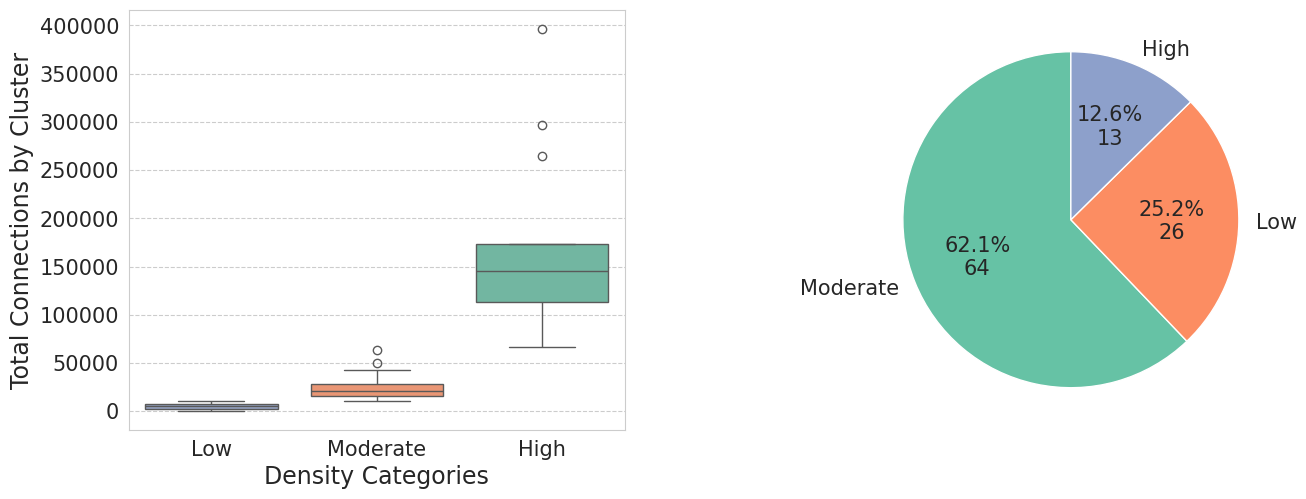

In [98]:
# Calculate the counts of each density category
density_counts = agg_cluster['density'].value_counts()

# Set colors for the pie chart using 'Set2' color palette
colors = sns.color_palette("Set2", len(density_counts))

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Boxplot -------------------------------------------------------

# Set seaborn style
sns.set_style("whitegrid", {'grid.linestyle': '--'})

# Create boxplot
axes[0] = sns.boxplot(x=agg_cluster.density, y=agg_cluster.conn_count, hue=agg_cluster.density, order=density_choices, palette=sns.color_palette("Set2", 3), ax=axes[0])

# Format boxplot
axes[0].tick_params(labelsize=15)
axes[0].set_xlabel("Density Categories", fontsize=17)
axes[0].set_ylabel("Total Connections by Cluster", fontsize=17)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# Pie chart -------------------------------------------------------

# Create pie chart
wedges, texts, autotexts = axes[1].pie(density_counts, labels=density_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 15})

# Add absolute counts to the pie chart
for i, autotext in enumerate(autotexts):
    autotext.set_text(f"{autotext.get_text()}\n{density_counts.iloc[i]}")

# Add title and legend
#axes[1].legend(title="Density", loc="best", bbox_to_anchor=(1, 0.5))

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.35, top=0.95, wspace=0.4)

# Save the figure
plt.savefig('combined_plots.png', format='png', dpi=300)

plt.show()

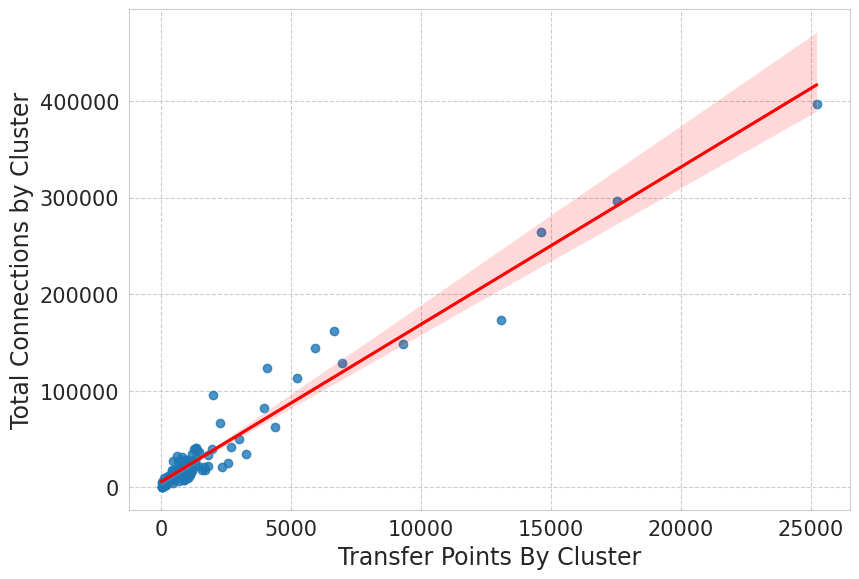

In [99]:
fig, axes = plt.subplots(figsize = (9.3, 6.5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.regplot(x = agg_cluster.transfer_count, y = agg_cluster.conn_count, ci = 95, ax = axes, line_kws = {'color': 'red'})
g.tick_params(labelsize = 15)
g.set_xlabel("Transfer Points By Cluster", fontsize = 17)
g.set_ylabel("Total Connections by Cluster", fontsize = 17);

In [100]:
scipy.stats.pearsonr(x = agg_cluster.transfer_count, y = agg_cluster.conn_count)

PearsonRResult(statistic=0.9721835314661409, pvalue=1.7490508939489825e-65)

In [101]:
map_cluster = pd.merge(df_cluster, bs.filter(['dummy_legacy_id', 'latitude', 'longitude', 'name_normalized', 'type_norm']), left_on = 'dummy_legacy_id_u', right_on = 'dummy_legacy_id')
map_cluster.rename(columns = {'latitude': 'latitude_u', 'longitude': 'longitude_u', 'name_normalized': 'name_norm_u', 'type_norm': 'type_norm_u'}, inplace = True)
map_cluster.drop(columns = 'dummy_legacy_id', axis = 1, inplace = True)

map_cluster = pd.merge(map_cluster, bs.filter(['dummy_legacy_id', 'latitude', 'longitude', 'name_normalized', 'type_norm']), left_on = 'dummy_legacy_id_v', right_on = 'dummy_legacy_id')
map_cluster.rename(columns={'latitude': 'latitude_v', 'longitude': 'longitude_v', 'name_normalized': 'name_norm_v', 'type_norm': 'type_norm_v'}, inplace = True)
map_cluster.drop(columns = 'dummy_legacy_id', axis = 1, inplace = True)

<h3>Map by Cluster Density</h3>

In [102]:
mapa = folium.Map(
    location = [-25.4284, -49.2733],
    tiles = "OpenStreetMap",
    zoom_start = 12
)

markers = []
for density in density_choices:

    feature_group = folium.FeatureGroup(density)
    cluster_numbers = folium.FeatureGroup(f'Cluster Numbers ({density})')
    
    centers = []
    points = []    
    idx = list(agg_cluster.query(f"density == '{density}'").cluster.drop_duplicates())
    for index, conn in map_cluster.query(f"cluster == {idx}").filter(['latitude_u', 'longitude_u', 'name_norm_u', 'type_norm_u', 'latitude_v',
           'longitude_v', 'name_norm_v', 'type_norm_v', 'cluster']).drop_duplicates().iterrows():
        
        u = [conn['latitude_u'], conn['longitude_u']]
        v = [conn['latitude_v'], conn['longitude_v']]
        line = folium.PolyLine([u, v], color = 'red', weight = 1.0).add_to(feature_group)
        centre = bus_stop_clustered.query(f"centre == 1 and cluster == {conn['cluster']}").filter(['latitude', 'longitude']).values.tolist()[0]
        if centre not in centers:
            folium.Circle(centre, popup = conn["cluster"],
                radius = 600, color = 'blue', fill_color = 'blue', fill = True, opacity = 1, fill_opacity = 0.1, weight = 1.0).add_to(feature_group)
            folium.map.Marker(
                centre,
                icon=folium.DivIcon(
                    icon_size=(150,36),
                    icon_anchor=(0,0),
                    html='<div style="font-size: 12pt; font-weight: bold; color: black">%s</div>' % conn['cluster'],
                    )
                ).add_to(cluster_numbers)            
            centers.append(centre)
            
        if u not in points:
            markers.append(folium.Circle(u, popup = conn["name_norm_u"],
                radius = 3, color = 'black', fill_color = 'black', fill = True, opacity = 1, fill_opacity = 1, weight = 1.0).add_to(feature_group))
            points.append(u)
            
        if v not in points:
            markers.append(folium.Circle(v, popup = conn["name_norm_v"],
                radius = 3, color = 'black', fill_color = 'black', fill = True, opacity = 1, fill_opacity = 1, weight = 1.0).add_to(feature_group))
            points.append(v)
            
        mapa.add_child(feature_group)
        mapa.add_child(cluster_numbers)

folium.GeoJson(gpd.read_file('maps/PR_Municipios_2022.shp').query("NM_MUN == 'Curitiba'"),
             style_function=lambda x: {'color': 'black', 'fillOpacity': 0, 'weight': 1.5}).add_to(mapa)        
        
mapa.add_child(folium.LayerControl())
mapa.keep_in_front(*markers)
plugins.Fullscreen(                                                         
        position                = "topright",                                   
        title                   = "Open full-screen map",                       
        title_cancel            = "Close full-screen map",                      
        force_separate_button   = True,                                         
    ).add_to(mapa) 

mapa.save(outfile = "density_map.html")
web.open_new_tab("density_map.html")

False

In [92]:
cluster_high = list(agg_cluster.query(f"density == '{density_choices[2]}'").cluster)
df_cluster.query(f"cluster == {cluster_high}").head()

,dummy_legacy_id_u,dummy_legacy_id_v,line_code_u,line_code_v,group_id,conn_count,bus_count_u,bus_count_v,min_bus_count,conn_count_normalized,legacy_id,cluster
0,101004,101005,876,207,0,41,34.0,53.0,34.0,0.180477,101004,18
1,101004,101005,876,260,1,12,34.0,12.0,12.0,0.148607,101004,18
2,101004,101161,876,205,2,46,34.0,74.0,34.0,0.203242,101004,18
3,101004,101163,876,275,3,18,34.0,26.0,26.0,0.100976,101004,18
4,101004,103203,876,372,4,30,34.0,52.0,34.0,0.130395,101004,18


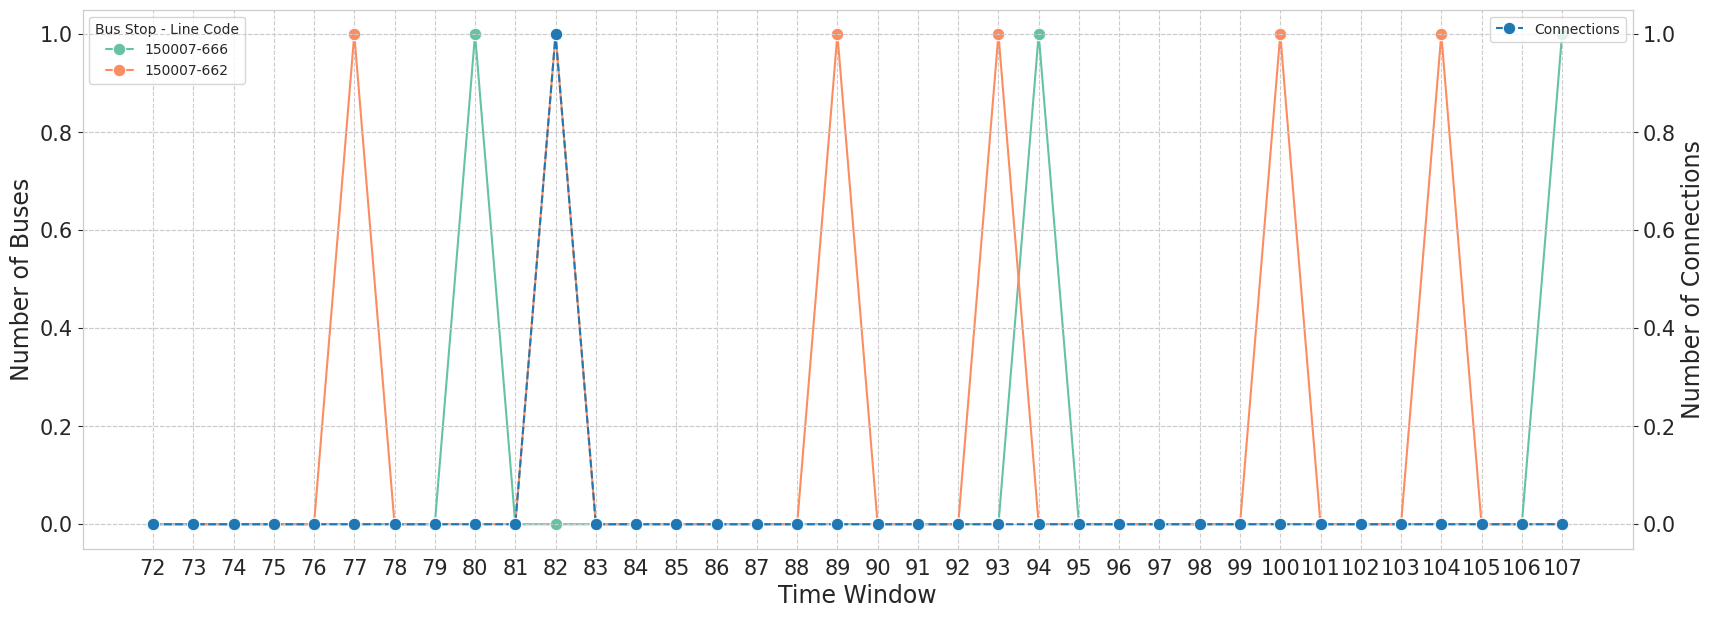

In [103]:
group_id = 103203
period = 'Morning'

edge_info = df_cluster.query(f"group_id == {group_id}")
if (edge_info['bus_count_u'] < edge_info['bus_count_v']).bool():
    minor_id = list(edge_info[['dummy_legacy_id_u', 'line_code_u']].itertuples(index=False, name=None))[0]
    bigger_id = list(edge_info[['dummy_legacy_id_v', 'line_code_v']].itertuples(index=False, name=None))[0]
else:
    minor_id = list(edge_info[['dummy_legacy_id_v', 'line_code_v']].itertuples(index=False, name=None))[0]
    bigger_id = list(edge_info[['dummy_legacy_id_u', 'line_code_u']].itertuples(index=False, name=None))[0]

ba = df_bus_availability.query(f"period == '{period}'").copy()
df0 = ba.query(f"(dummy_legacy_id == {minor_id[0]} and line_code == '{minor_id[1]}') or (dummy_legacy_id == {bigger_id[0]} and line_code == '{bigger_id[1]}')").copy()
df0['label'] = df0['dummy_legacy_id'].astype(str) + "-" + df0['line_code']
pe = positive_edges.query(f"period == '{period}' and group_id == {group_id} and duration >= {cd[0]} and duration <= {cd[1]}").copy()
pe['time_window'] = (60 * pe["event_timestamp_v"].dt.hour + pe["event_timestamp_v"].dt.minute).floordiv(tw)
df1 = pd.merge(df0.time_window.drop_duplicates(), pe.groupby('time_window').size().reset_index(name='conn_count'), how = 'left').fillna(0)

fig, axes = plt.subplots(figsize = (20, 7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g0 = sns.lineplot(x = df0.time_window, y = df0.bus_count, estimator = 'mean', errorbar = ('ci', 95), hue = df0.label, hue_order = ["%s-%s" % (minor_id[0], minor_id[1]), "%s-%s" % (bigger_id[0], bigger_id[1])], legend = True, palette = sns.color_palette("Set2", 2), marker = 'o', markersize = 9, linestyle = "solid",)
g0.tick_params(labelsize = 15)
g0.set_ylabel("Number of Buses", fontsize = 17)
g0.set_xlabel("Time Window", fontsize = 17)
g0.set_xticks(df0.time_window.drop_duplicates())
plt.legend(title = 'Bus Stop - Line Code', loc = 'upper left')

g1 = sns.lineplot(x = df1.time_window, y = df1.conn_count, marker = 'o', markersize = 9, linestyle = "dashed", ax = g0.axes.twinx(), label = 'Connections')
g1.tick_params(labelsize = 15)
g1.set_ylabel("Number of Connections", fontsize = 17);

# Ajustando a escala do eixo y
ymin = min(g0.get_ylim()[0], g1.get_ylim()[0])
ymax = max(g0.get_ylim()[1], g1.get_ylim()[1])

g0.set_ylim(ymin, ymax)
g1.set_ylim(ymin, ymax);

<h3>Build dataset to send to LSTM</h3>

In [104]:
def build_dataset(group_id):
    edge_info = df_cluster.query(f"group_id == {group_id}")
    if (edge_info['bus_count_u'] < edge_info['bus_count_v']).bool():
        minor_id = list(edge_info[['dummy_legacy_id_u', 'line_code_u']].itertuples(index=False, name=None))[0]
        bigger_id = list(edge_info[['dummy_legacy_id_v', 'line_code_v']].itertuples(index=False, name=None))[0]
    else:
        minor_id = list(edge_info[['dummy_legacy_id_v', 'line_code_v']].itertuples(index=False, name=None))[0]
        bigger_id = list(edge_info[['dummy_legacy_id_u', 'line_code_u']].itertuples(index=False, name=None))[0]
    minor_df = df_bus_availability.query(f"dummy_legacy_id == {minor_id[0]} and line_code == '{minor_id[1]}'").filter(['time_window', 'bus_count']).copy()
    minor_df['series'] = 'minor'
    bigger_df = df_bus_availability.query(f"dummy_legacy_id == {bigger_id[0]} and line_code == '{bigger_id[1]}'").filter(['time_window', 'bus_count']).copy()
    bigger_df['series'] = 'bigger'
    bus_count_df = pd.concat([minor_df, bigger_df], ignore_index = True)
    bus_count_df.rename({'bus_count': 'value'}, axis = 1, inplace = True)
    pe = positive_edges.query(f"group_id == {group_id} and duration >= {cd[0]} and duration <= {cd[1]}").copy()
    pe['time_window'] = (60 * pe["event_timestamp_v"].dt.hour + pe["event_timestamp_v"].dt.minute).floordiv(tw)
    pe_df = pd.merge(bus_count_df.time_window.drop_duplicates(), pe.groupby('time_window').size().reset_index(name='conn_count'), how = 'left').fillna(0)
    pe_df['series'] = 'connection'
    pe_df.rename({'conn_count': 'value'}, axis = 1, inplace = True)
    lstm_df = pd.concat([bus_count_df, pe_df], ignore_index = True)
    lstm_df['group_id'] = group_id
    lstm_df['cluster'] = edge_info.cluster.values[0]
    return lstm_df

In [116]:
agg_cluster.to_parquet('agg_cluster.parquet')

In [114]:
df_bus_availability.to_parquet('df_bus_availability.parquet')

In [115]:
positive_edges.to_parquet('positive_edges.parquet')

In [111]:
lstm_dfs = []
c = 0
group_ids = list(df_cluster.query(f"cluster == {cluster_high}").group_id)
for group_id in group_ids:
    lstm_dfs.append(build_dataset(group_id))
    c = c + 1
    if (c % 100 == 0):
        print("%d / %d" % (c, len(group_ids)))

100 / 116794



KeyboardInterrupt



In [112]:
import threading
from concurrent.futures import ThreadPoolExecutor

def build_dataset_thread(group_ids, lstm_dfs, semaphore):
    """Builds the dataset for a list of group IDs, appends them to the lstm_dfs list,
       and releases the semaphore when done.
    """
    for group_id in group_ids:
        lstm_dfs.append(build_dataset(group_id))
    semaphore.release()  # Signal that this thread has finished

lstm_dfs = []
group_ids = list(df_cluster.query(f"cluster == {cluster_high}").group_id)

# Create a semaphore to track completed threads
semaphore = threading.Semaphore(0)  

# Divide group_ids into chunks of 1,000
chunk_size = 1000
group_id_chunks = [group_ids[i:i + chunk_size] for i in range(0, len(group_ids), chunk_size)]

with ThreadPoolExecutor(max_workers=4) as executor:
    for chunk in group_id_chunks:
        executor.submit(build_dataset_thread, chunk, lstm_dfs, semaphore)

    c = 0
    # Wait for all threads to finish (using semaphore)
    for _ in range(len(group_id_chunks)):
        semaphore.acquire()
        c += 1
        if c % 100 == 0:
            print(f"{c} / {len(group_id_chunks)}")

# lstm_dfs will contain the datasets for each group

KeyboardInterrupt: 

In [95]:
df = pd.concat(lstm_dfs)
df.head()

,time_window,value,series,group_id,cluster
0,72,0.0,minor,0,18
1,88,0.0,minor,0,18
2,105,1.0,minor,0,18
3,119,1.0,minor,0,18
4,136,0.0,minor,0,18


In [75]:
edge_info = df_cluster.query(f"group_id == 146257")

In [88]:
edge_info.cluster.values[0]

1

In [33]:
df = pd.concat(lstm_dfs)
df = df.pivot(index = ['agg_cluster_id', 'time_window'], columns = 'series', values = 'value').reset_index()
df.filter(['agg_cluster_id', 'time_window', 'minor', 'bigger', 'connection']).to_parquet('lstm_df.parquet', index = None)